In [1]:
import os
import pandas as pd 
import numpy as np
from natsort import natsorted
from natsort import natsort_keygen

pd.set_option('display.max_rows', 10)

from sklearn.metrics import pairwise_distances
import nilearn
from nilearn.connectome import ConnectivityMeasure


In [2]:
import nibabel as nb
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
                                                    data_dir=None, base_url=None, resume=True, verbose=1)
'''
From the documentation:
The list of labels does not contain ‘Background’ by default. 
To have proper indexing, you should either manually add ‘Background’ to the list of labels:
'''

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

masker = NiftiLabelsMasker(
    labels_img=schaefer_atlas.maps,
    strategy='mean',  # Averages voxels in parcel at each TR
    standardize=False  # don't want z-scoring
)

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


# <font color='purple'>IS-RSA</font>

We take our parcellated timeseries for each of our clips, with each subject per row, and create a correlation matrix. We take the lower triangle of this correlated matrix and then correlate it with the lower triangle of the behavioral rating data correlation matrix.  

We will do this for each movie separately.

In [14]:
#Important! Insert the correct variables before running:

type = "_"+"NIM"


In [15]:
segmented_clip_path = '/Volumes/LT/phd/inarr/'
sublist = [x for x in os.listdir(segmented_clip_path) if 'sub' in x]
complete_cliplist = []

#compile all of the clip files across subjects
for sub in sublist:
    try:
        segment_list = [x for x in os.listdir(segmented_clip_path+sub+os.sep+"segmented_files/") if type in x]

        for f in segment_list:
            complete_cliplist.append(f)
    except:
        continue

movie_list = ['physical', 'stutterer']

im_clips = ['clip-1','clip-3','clip-5','clip-7','clip-9','clip-11','clip-13',
             'clip-15','clip-17','clip-19','clip-21','clip-23']

nim_clips = ['clip-0','clip-2','clip-4','clip-6','clip-8','clip-10','clip-12',
             'clip-14','clip-16','clip-18','clip-20','clip-22','clip-24']

df = pd.read_csv('behavioral_matrix.csv')
phys_df = df[(df.target == 'physical')].copy()
stut_df = df[(df.target == 'stutterer')].copy()

phys_df.sort_values(by=['version', 'subID'], key=natsort_keygen(), inplace=True)
stut_df.sort_values(by=['version', 'subID'], key=natsort_keygen(), inplace=True)

In [6]:
phys_X = phys_df[['bossy','conscientious', 'easygoing', 'humble', 'nosy', 'rebellious']].values
phys_distance_matrix = pairwise_distances(phys_X, metric='euclidean')

stut_X = stut_df[['bossy','conscientious', 'easygoing', 'humble', 'nosy', 'rebellious']].values
stut_distance_matrix = pairwise_distances(stut_X, metric='euclidean')

In [16]:
for movie in movie_list:

    if movie == 'physical':
        distance_matrix =  phys_distance_matrix
    elif movie == 'stutterer':
         distance_matrix = stut_distance_matrix

    movie_cliplist = [x for x in complete_cliplist if movie in x]

    """
    IM/NIM
    """
    clip_to_behavior_correlation = np.zeros([13,400]) #IM is 12, NIM is 13

    """
    IM/NIM
    """
    for ix, i in enumerate(nim_clips):
        print("starting clip:", i)
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]
        
        #this ensures that the subject order matches the distance_matrices orders
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]

            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]

            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) 
            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list)

        for p in range(400):

            subject_by_timeseries = [] # eg., clip-0 has 28 subjects, and a timeseries of 78

            for subject in range(single_clip_mat_arr.shape[0]): #go through each subject
                subject_by_timeseries.append(single_clip_mat_arr[subject,:,p]) #grab the clip timeseries

            clipdf = pd.DataFrame(subject_by_timeseries)
            cliparr = np.corrcoef(clipdf)

            neural_lower = nilearn.connectome.sym_matrix_to_vec(cliparr, discard_diagonal=True)
            behavior_lower = nilearn.connectome.sym_matrix_to_vec(distance_matrix, discard_diagonal=True)

            result = np.corrcoef(neural_lower, behavior_lower)[0][1]
            clip_to_behavior_correlation[ix,p] = result
    
    output = pd.DataFrame(clip_to_behavior_correlation)
    
    """
    IM/NIM
    """
    output.to_csv(movie+"_clips_by_parcel_NIM.csv")


starting clip: clip-0
starting clip: clip-2
starting clip: clip-4
starting clip: clip-6
starting clip: clip-8
starting clip: clip-10
starting clip: clip-12
starting clip: clip-14
starting clip: clip-16
starting clip: clip-18
starting clip: clip-20
starting clip: clip-22
starting clip: clip-24
starting clip: clip-0
starting clip: clip-2
starting clip: clip-4
starting clip: clip-6
starting clip: clip-8
starting clip: clip-10
starting clip: clip-12
starting clip: clip-14
starting clip: clip-16
starting clip: clip-18
starting clip: clip-20
starting clip: clip-22
starting clip: clip-24


### <font color ='turquoise'> Averaging the results & Plotting </font>

In [8]:
#read in the IM and NIM dataframes, average them across clips and then average them across movies

phys_im, stut_im = pd.read_csv('physical_clips_by_parcel_IM.csv', index_col=0), pd.read_csv('stutterer_clips_by_parcel_IM.csv', index_col=0)
phys_nim, stut_nim = pd.read_csv('physical_clips_by_parcel_NIM.csv',index_col=0), pd.read_csv('stutterer_clips_by_parcel_NIM.csv',index_col=0)

phys_im_avg, stut_im_avg = phys_im.mean(axis=0).reset_index(drop=True), stut_im.mean(axis=0).reset_index(drop=True)
phys_nim_avg, stut_nim_avg = phys_nim.mean(axis=0).reset_index(drop=True), stut_nim.mean(axis=0).reset_index(drop=True)

im_avg = list((phys_im_avg + stut_im_avg) / 2)
nim_avg = list((phys_nim_avg + stut_nim_avg) / 2)

In [9]:
from nilearn import plotting, datasets, image, surface
import nibabel as nb
from nilearn.plotting import plot_img_on_surf
from nilearn.image import new_img_like

fsaverage = datasets.fetch_surf_fsaverage()

schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=1,
    data_dir=None, base_url=None, resume=True, verbose=1)

schaefer_atlas.labels = np.insert(schaefer_atlas.labels, 0, "Background")

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/schaefer_2018


### Internal monologues (uncorrected)

In [10]:
atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()
affine = atlas.affine

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = im_avg[i] 

# #Create corrected p-value mask:
# n_rois = 399

# roi_data = image.get_data(atlas)  # (x,y,z) array with ROI labels
# significant_mask = np.zeros_like(roi_data, dtype=np.float32)

# for roi_label in range(1, n_rois+1):
#     if significant[roi_label-1] == 1:  # ROI labels start at 1
#         significant_mask[roi_data == roi_label] = 1  # Tag significant voxels


In [11]:
im_corr_img = nb.Nifti1Image(mapped_data, affine)
nb.save(im_corr_img, 'im_corr_map.nii.gz')

[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


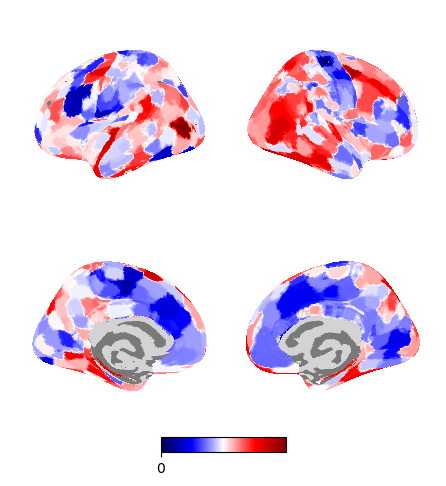

In [13]:
plotting.plot_img_on_surf(im_corr_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    # vmin=0, vmax=.4, #removing these options to let it be automatic
)

plotting.show()

### No internal Monologues (uncorrected)

In [17]:
atlas = nb.load(schaefer_atlas.maps) # .maps provides the path to the map
atlas_data = atlas.get_fdata()
affine = atlas.affine

mapped_data = np.zeros_like(atlas_data)
mapped_data[atlas_data == 0] = np.nan # mark
unique_regions = np.unique(atlas_data)[1:]

for i, region in enumerate(unique_regions):
    mapped_data[atlas_data == region] = nim_avg[i] 

nim_corr_img = nb.Nifti1Image(mapped_data, affine)
nb.save(nim_corr_img, 'nim_corr_map.nii.gz')


[get_dataset_dir] Dataset found in /Users/lindseytepfer/nilearn_data/fsaverage


/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/lindseytepfer/miniconda3/lib/python3.11/site-packages/nilearn/surface/surface.py:540: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


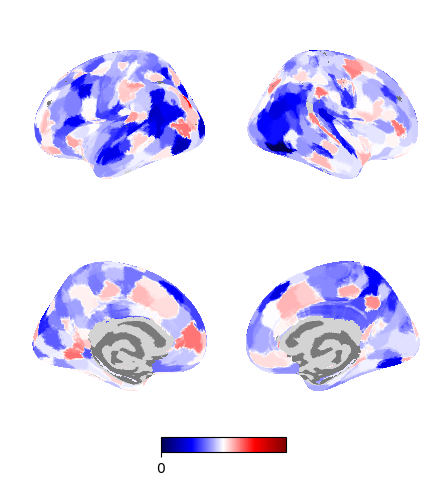

In [18]:
plotting.plot_img_on_surf(nim_corr_img,
    "fsaverage", inflate=True,
    views=['lateral', 'medial'],  # Hemispheric views to display
    hemispheres=['left', 'right'],  # Both hemispheres
    #threshold=0.05,  # Highlight significant p-values
    cmap='seismic',  # Colormap (e.g., 'viridis', 'coolwarm')
    colorbar=True,  # Show colorbar
    # vmin=0, vmax=.4, #removing these options to let it be automatic
)

plotting.show()

### If time allows, we will test our results with a permutation test

In [ ]:
for movie in movie_list:

    if movie == 'physical':
        distance_matrix =  phys_distance_matrix
    elif movie == 'stutterer':
         distance_matrix = stut_distance_matrix

    movie_cliplist = [x for x in complete_cliplist if movie in x]

    """
    IM/NIM
    """
    clip_to_behavior_correlation = np.zeros([13,400,10]) #IM is 12, NIM is 13, 400 parcels, num. permutations

    """
    IM/NIM
    """
    for ix, i in enumerate(nim_clips):
        print("starting clip:", i)
        filtered_clips = [x for x in movie_cliplist if i+"_" in x]
        
        #this ensures that the subject order matches the distance_matrices orders
        v1_clips = natsorted([x for x in filtered_clips if 'version-1' in x])
        v2_clips = natsorted([x for x in filtered_clips if 'version-2' in x])

        single_clip_matrix_list = []

        for clip in v1_clips:

            sub = clip.split("_")[0]

            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) #producess a timepoint x parcel csv, eg (2, 400)
            single_clip_matrix_list.append(time_by_parcel)
        
        for clip in v2_clips:

            sub = clip.split("_")[0]

            clip_segment_nii = nb.load(segmented_clip_path+sub+'/segmented_files/'+clip)

            time_by_parcel = masker.fit_transform(clip_segment_nii) 
            single_clip_matrix_list.append(time_by_parcel)
        
        single_clip_mat_arr = np.array(single_clip_matrix_list)

        for p in range(400):
            
            np.random.seed(0)

            subject_by_timeseries = [] # eg., clip-0 has 28 subjects, and a timeseries of 78

            for subject in range(single_clip_mat_arr.shape[0]): #go through each subject
                subject_by_timeseries.append(single_clip_mat_arr[subject,:,p]) #grab the clip timeseries

            clipdf = pd.DataFrame(subject_by_timeseries)
            cliparr = np.corrcoef(clipdf)

            for perm in range(10):
                shuffled_matrix = cliparr[np.random.permutation(28)][:, np.random.permutation(28)]

                neural_lower = nilearn.connectome.sym_matrix_to_vec(cliparr, discard_diagonal=True)
                behavior_lower = nilearn.connectome.sym_matrix_to_vec(distance_matrix, discard_diagonal=True)

                result = np.corrcoef(neural_lower, behavior_lower)[0][1]
                clip_to_behavior_correlation[ix,p,perm] = result
    
    output = pd.DataFrame(clip_to_behavior_correlation)
    
    """
    IM/NIM
    """
    output.to_csv(movie+"_clips_by_parcel_NIM.csv")
